first try at SCSA on EEG for epileptic spikes and seizure detection

##### libraries

In [ ]:
pip install mat73 antropy EntropyHub nolds mne neurokit2 celluloid opencv-python BaselineRemoval

In [3]:
# upload required libraries and modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags
from sklearn.preprocessing import normalize
from scipy.special import logsumexp
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.fft import fftshift
import mat73
import antropy as ant
import seaborn as sns
import nolds as nd
import warnings
import EntropyHub as EH
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import feature_selection as fs
import mne
import neurokit2 as nk
from tensorflow import keras
from celluloid import Camera
from numpy import zeros, ones
from numpy.random import randint, randn
from keras.utils.vis_utils import plot_model
from scipy import signal
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Reshape, Input, Dropout, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from keras.models import Sequential
from keras import optimizers
from numpy import vstack
import matplotlib as mpl
import cv2 as cv
from skimage.feature import hog 
import cmath
import os
import itertools
from numpy import expand_dims
from tensorflow.keras.optimizers import Adam
# %matplotlib inline 
# %config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")

##### Implementation of the SCSA algorithm

In [5]:
#see reference 
#
# T.-M. Laleg-Kirati, E. Crépeau, and M. Sorine, “Semi-classical signal
# analysis,” Mathematics of Control, Signals, and Systems, vol. 25,
#no. 1, pp. 37–61, 2013.

def SCSA(y_sig, h):
    M = len(y_sig)
    diff_2 = diff_matrix(M)
    Y = np.diag(y_sig)
    mat = -diff_2 -(1/h**2)*Y
    lamda, psi = np.linalg.eigh(mat)
    eig = np.diag(lamda)
    neg_ind = np.where(eig <0)
    neg_spec = eig[neg_ind[0], neg_ind[0]]
    Nh = neg_spec.shape[0]
    neg_psi = psi[:, neg_ind[0]]
    kappa = np.diag((-neg_spec)**(0.5))
    neg_psi = normalize(neg_psi, norm = 'l2', axis=0)
    y_scsa = 4*(h*h)*np.sum((neg_psi**2)@kappa, 1)
    return y_scsa, kappa, neg_psi, Nh

def ind_gen(M):
    indd = list()
    for index in np.ndindex(M, M):
        i,j = index
        ind = np.abs(i-j)
        if ind == 0:
            ind = 1
        indd.append(ind)
    ID = pd.DataFrame(np.array(indd).reshape(M,M))
    return ID.values

def diff_matrix(M):
    delta = 2*np.pi/M
    delta_t = 1
    ID = ind_gen(M)
    if (M%2) == 0:
        diag_D2 = (-(np.pi)**2/(3*delta**2)-1/6)*np.eye(M)
        D_2 = -0.5*((-1)**(ID))*(1/(np.sin((ID)*delta/2))**2)
    else : 
        diag_D2 = (-(np.pi)**2/(3*delta**2)-1/12)*np.eye(M)
        D_2 = -0.5*(-1)**(ID)*(1/((np.sin((ID)*delta/2))))*(1/np.tan((ID)*delta/2))
    trans_D2 = D_2 - diags(np.diag(D_2)) + diag_D2
    D_2 = ((delta/delta_t)**2)*trans_D2
    return D_2

##### Demonstration of the SCSA reconstruction

In [6]:
#generation of standard analytical signals for illustration purpose
y = [np.sin(t/100)+np.cos(t/40)+3 for t in range(0, 300)]
y2 = [(np.sin(40*t/40)+np.cos(100*t/15+3)+0.3*np.tanh(6*t)+2) for t in range(0, 300)]

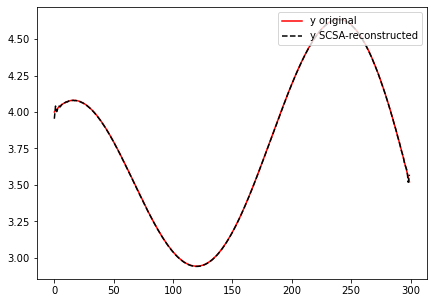

In [7]:
# SCSA reconstruction on signal "y"
y_scsa, kappa, neg_psi, Nh= SCSA(y, 1.9)
plt.figure(figsize=(7,5))
plt.plot(y, 'r', label='y original')
plt.plot(y_scsa, '--', c='black', label='y SCSA-reconstructed')
plt.legend(loc ='upper right')
plt.show()

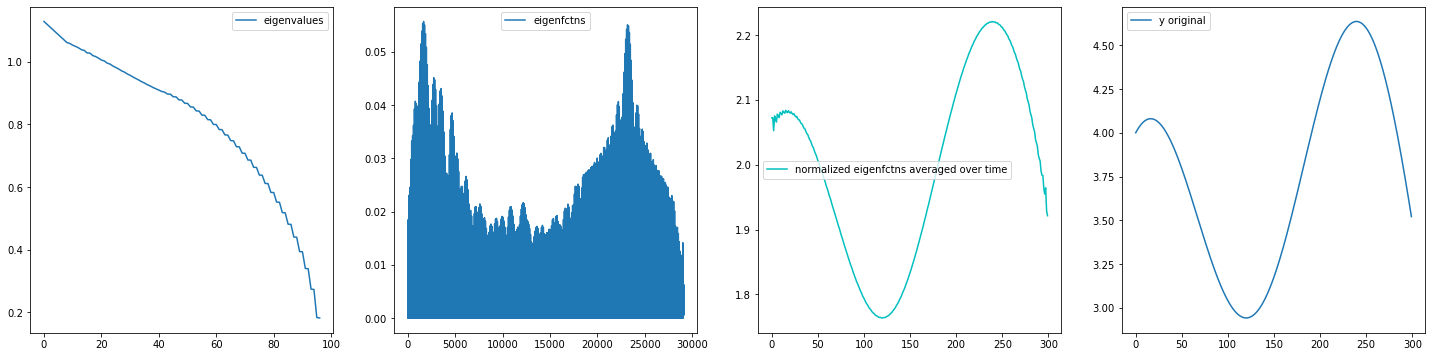

In [8]:
# visualization and analysis of SCSA components for "y"
fig2, axs = plt.subplots(1,4)
fig2.set_size_inches(25, 6)
axs[0].plot(kappa[np.where(kappa!=0)], label = 'eigenvalues')
axs[0].legend()
axs[1].plot(neg_psi[np.where(neg_psi!=0)]**2, label='eigenfctns')
axs[1].legend()
axs[2].plot(np.mean(neg_psi**2, axis=1)*600, 'c', label='normalized eigenfctns averaged over time')
axs[2].legend()
axs[3].plot(y, label='y original')
axs[3].legend()

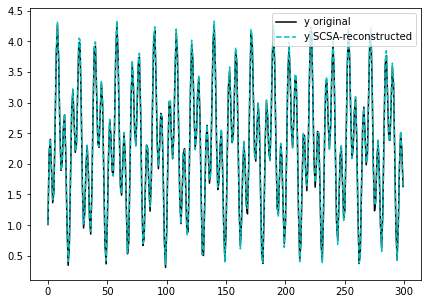

In [9]:
# SCSA reconstruction on signal "y2"
a, b, c, d = SCSA(y2, 0.7)
plt.figure(figsize=(7,5))
plt.plot(y2, 'black', label='y original')
plt.plot(a, 'c--', label='y SCSA-reconstructed')
plt.legend(loc ='upper right')
plt.show()

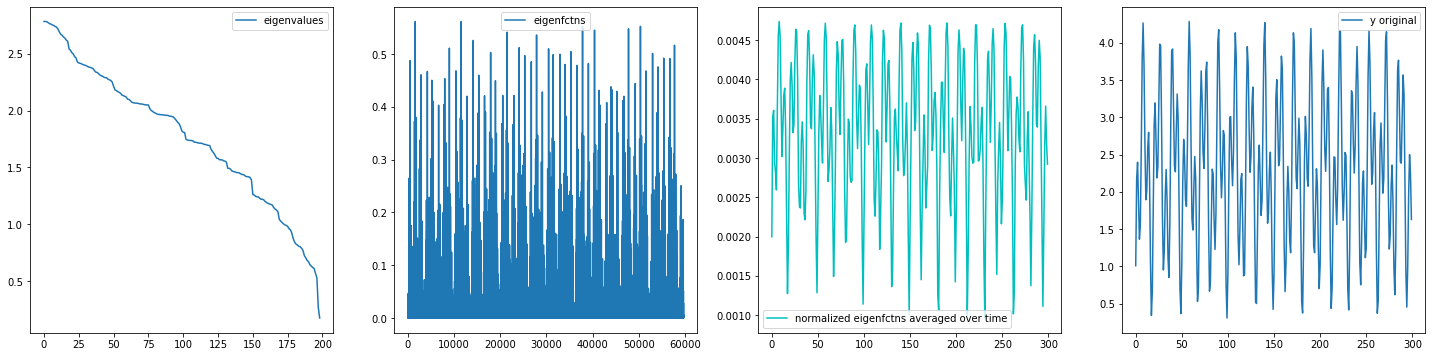

In [10]:
# visualization and analysis of SCSA components for "y2"
fig2, axs = plt.subplots(1,4)
fig2.set_size_inches(25, 6)
axs[0].plot(b[np.where(b!=0)], label = 'eigenvalues')
axs[0].legend()
axs[1].plot(c[np.where(c!=0)]**2, label='eigenfctns')
axs[1].legend()
axs[2].plot(np.mean(c**2, axis=1), 'c', label='normalized eigenfctns averaged over time')
axs[2].legend()
axs[3].plot(y2, label='y original')
axs[3].legend()

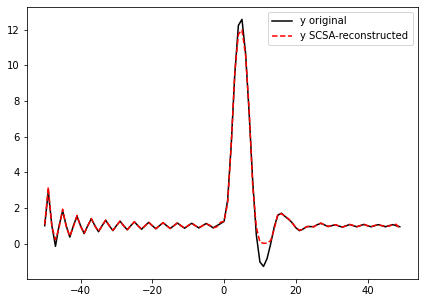

In [17]:
#example n°3 of SCSA reconstruction using apulse shaped signal defined as "response"
imp = signal.unit_impulse(100, 'mid')
b, a = signal.butter(4, 0.2)
t = [5.5*(i+2) for i in range(100)]
response = 50*signal.lfilter(b, a, imp) +1 + 100*np.sinc(t)
plt.figure(figsize=(7,5))
plt.plot(np.arange(-50, 50), response, 'black', label='y original')
h=1
y_scsa, kappa, neg_psi, Nh = SCSA(response, h)
plt.plot(np.arange(-50, 50), y_scsa,  'r--', label='y SCSA-reconstructed')
plt.legend(loc ='upper right')

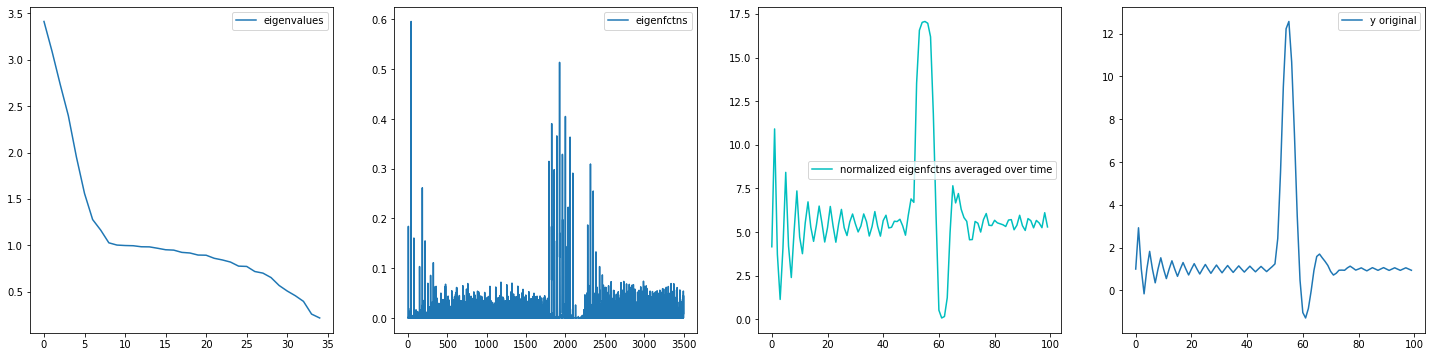

In [18]:
# visualization and analysis of SCSA components for "response"
fig2, axs = plt.subplots(1,4)
fig2.set_size_inches(25, 6)
axs[0].plot(kappa[np.where(kappa!=0)], label = 'eigenvalues')
axs[0].legend()
axs[1].plot(neg_psi[np.where(neg_psi!=0)]**2, label='eigenfctns')
axs[1].legend()
axs[2].plot(np.mean(neg_psi**2, axis=1)*600, 'c', label='normalized eigenfctns averaged over time')
axs[2].legend()
axs[3].plot(response, label='y original')
axs[3].legend()

In [19]:
#computing the mean square error for signal "response" for different values of h
NN = []
k1 = []
k2 = []
k3 = []
k4 = []
hh = [1.4 + 0.2*i for i in range(0, 60)]
H = [1/(1.4 + 0.2*i)**2 for i in range(0, 60)]
# H.sort()
mse = []
for h in hh:
    y_scsa, kappa, neg_psi, Nh= SCSA(response, h)
    NN.append(Nh)
    k1.append(-kappa[np.where(kappa!=0)][0]**2)
    k2.append(-kappa[np.where(kappa!=0)][1]**2)
    k3.append(-kappa[np.where(kappa!=0)][2]**2)
    # k4.append(-kappa[np.where(kappa!=0)][3]**2)
    ms = np.mean(response-y_scsa)**2
    mse.append(ms)

Text(0.5, 0, '$\\chi$')

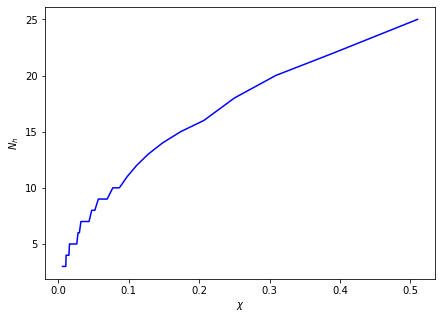

<Figure size 432x288 with 0 Axes>

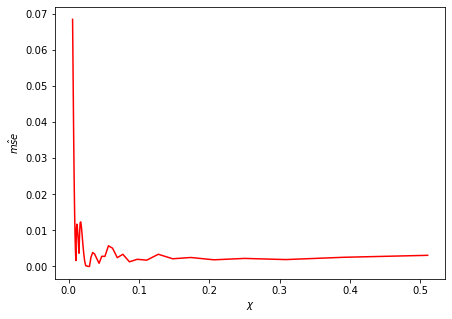

<Figure size 432x288 with 0 Axes>

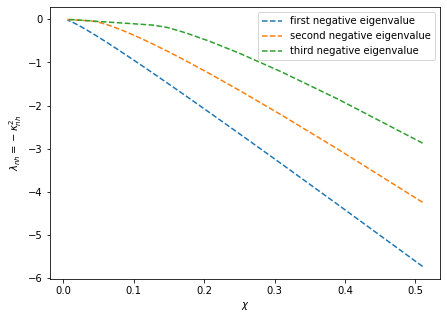

In [20]:
# evolution of the number of eigenvalues Nh w.r.t X=1/h**2
plt.figure(figsize=(7,5))
plt.plot(H, NN, 'blue')
plt.xlabel('$\chi$')
plt.ylabel('$N_h$')
# evolution of the mse Nh w.r.t X=1/h**2
plt.figure()
plt.figure(figsize=(7,5))
plt.plot(H, mse, 'red')
plt.xlabel('$\chi$')
plt.ylabel('$\hat{mse}$')
# evolution of the number of the value of the first 3 eigenvalues kappa w.r.t X=1/h**2
plt.figure()
plt.figure(figsize=(7,5))
plt.plot(H, k1, '--', label = 'first negative eigenvalue')
plt.plot(H, k2, '--', label = 'second negative eigenvalue')
plt.plot(H, k3, '--', label='third negative eigenvalue')
plt.ylabel('$\lambda_{nh}=-\kappa_{nh}^2$')
plt.legend()
plt.xlabel('$\chi$')

##### Curvative-SCSA denoising

In [21]:
#see reference 
#
# P. Li and T. Laleg-Kirati, “Signal denoising based on the schrödinger
# operator’s eigenspectrum and a curvature constraint,” IET Signal
#Processing, vol. 15, 05 2021.
def C_SCSA(y_orig, beta, v):
    hmin= interv_H(y_orig,  beta)
    h=hmin
    h_interv=[]
    A = []
    B = []
    while h<50*hmin:
        h_interv.append(h)
        h=h+0.5
    costs = []
    for h in h_interv:
        y_h, kappa, neg_psi, Nh = SCSA(y_orig, h)
        y_d1 = np.gradient(y_h)
        y_d2 = np.gradient(y_d1)
        curv = np.abs(y_d2)/(1+y_d1**2)**1.5
        smooth = np.sum(curv)
        mu = v#mu_comp(y_orig, smooth, v)
        mse = np.sum((y_orig-y_h)**2)
        A.append(mu*smooth)
        B.append(mse)
        cost_i = mse + mu*smooth
        costs.append(cost_i)
    # cost_min = costs[costs.index(min(costs))]
    h_opt = h_interv[costs.index(min(costs))]
    return h_opt, A, B, costs

def mu_comp(y_orig, curv_sum, v):
    mx = max(y_orig)
    mu = (mx/curv_sum)*v
    return mu

#see reference 
#
#E. Piliouras and T.-M. Laleg-Kirati, “Quantum-based interval selec-
# tion of the semi-classical signal analysis method,” pp. 2294–2298,
# 2021.
def interv_H(y_sig, beta):
    M = len(y_sig)
    Ts = 1
    period = Ts*M
    Cn = fourierSeries_cn(period, M, y_sig)
    cn_sum = 0
    for i in range(1, int(M/2)):
        C = ((np.abs(Cn[i]))**2)/(2*(i)**2)
        cn_sum = cn_sum + C
    ymax = max(y_sig)
    A = ymax - np.real(Cn[0])
    hmin = beta*(Ts/np.pi)*ymax**0.5
    # hmax = ((M*Ts)/np.pi)*logsumexp(logsumexp(-cn_sum/A)**0.5)
    return hmin #, hmax

def fourierSeries_cn(period, N, y_sig):
    """Calculate the Fourier series coefficients an, bn up to the Nth harmonic"""
    result = []
    T = period
    t = np.arange(T)
    for n in range(N):
        c_plusn = (1/T) * (y_sig * np.exp(2j*np.pi*n*t/T)).sum()
        c_moinsn = (1/T)* (y_sig * np.exp(-2j*np.pi*n*t/T)).sum()
        cn = c_plusn+c_moinsn
        result.append(cn)
    return np.array(result)

In [22]:
y = [5*np.sin(t/20)+np.cos(t/4000)+19 for t in range(0, 300)]
y2 = [(5*np.sin(40*t/40)+np.cos(100*t/15+3)+0.3*np.tanh(6*t)+50) for t in range(0, 100)]
noise = 3*np.random.normal(0,0.6,300)

imp = signal.unit_impulse(100, 'mid')
b, a = signal.butter(4, 0.2)
response = 50*signal.lfilter(b, a, imp)+1

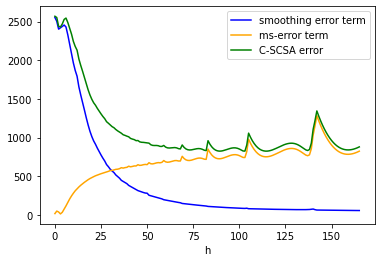

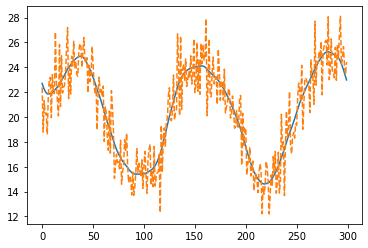

In [23]:
# plotting both error terms of the CSCSA for signal "y"
h, a, b, c= C_SCSA(y+noise, 1, 20)
plt.plot(a, 'b', label='smoothing error term')
plt.plot(b, 'orange', label='ms-error term')
plt.plot(c, 'g', label='C-SCSA error')
plt.xlabel('h')
plt.legend()
a, b, c, d = SCSA(y+noise, h)
plt.figure()
plt.plot(a)
plt.plot(y+noise, '--')

In [ ]:
h

In [ ]:
h, a, b, c= C_SCSA(response+noise, 1, 40)
plt.plot(a, 'b', label='smoothing error term')
plt.plot(b, 'orange', label='ms-error term')
plt.plot(c, 'g', label='C-SCSA error')
plt.xlabel('h')
plt.legend()
a, b, c, d = SCSA(response+noise, h)
plt.figure()
plt.plot(response+noise, '--')
plt.plot(a)
# plt.plot(response, '--')

##### Frequency subband filtering

In [4]:
# design butterworth bandpass filter for sampling freq=256
def filt(order, flow, fhigh, raw) :
  sos2 = signal.butter(order, flow, 'hp', fs=256, output='sos')
  sos3 = signal.butter(order, fhigh, 'lp', fs=256, output='sos')
  sig = signal.sosfiltfilt(sos3,signal.sosfiltfilt(sos2,raw))
  return sig

In [5]:
#function designed to filter the Bonn University Epilepsy dataset, one segment at a time and organize it
def filtering_df(dataframe, order, flow, fhigh, label):
    filtered_ep = pd.DataFrame(filt(order, flow, fhigh, np.array(maxMinNorm(dataframe.loc[dataframe['labels'] == label]['SEG' + str(1)])).reshape(-1)))
    for i in range(2, 101):
        sig = maxMinNorm(dataframe.loc[dataframe['labels'] == label]['SEG' + str(i)])
        filtered = pd.DataFrame(filt(order, flow, fhigh, np.array(sig).reshape(-1)))
        filtered_ep = pd.concat([filtered_ep, filtered], axis=1)
    return filtered_ep

##### Data Segmentation and windowing

In [6]:
#function to choose window from an array of windows
def choose_wind(windowed_data, window_numb):
    T = windowed_data[window_numb]
    T = T - min(T)
    D = np.array(T, dtype=np.float64)
    wind_for_SCSA = D.flatten()
    return wind_for_SCSA

#function to window data with overlap and length to precise
def windowing(data, size, step):
    last_start = data.shape[0] - 173*size + 1
    period_starts = range(0, last_start, 173*step)
    reshaped_data = np.concatenate(
                    [data[k:k+173*size] for k in period_starts],
                    axis=1).reshape(-1, 173*size, data.shape[1])
    return reshaped_data

##### Bonn Uni. data

In [990]:
#upload the Bonn University dataset using paths on user's local machine
def def_dat():
    dataf = pd.DataFrame()
    for i in range(1, 101):
        data_ep = pd.read_csv("C:/Users/Sara/Desktop/PFE/BonnU_data/S/S" + str(i) + ".txt")
        dataf = pd.concat([dataf, data_ep], axis=1)
    dataf.columns = ['SEG' + str(i) for i in range(1, 101)]
    return dataf

In [991]:
#S
dat_ep = def_dat()

L_ep = pd.DataFrame([1 for i in range(4096)])

dat_ep = pd.concat([dat_ep, L_ep], axis=1)

In [29]:
#replace "S" in path with "Z"
dat_nep = def_dat()

L_nep = pd.DataFrame([0 for i in range(4096)])

dat_nep = pd.concat([dat_nep, L_nep], axis=1)

In [34]:
#replace "S" in path with "O"
dat_nep2 = def_dat()

L_nep = pd.DataFrame([0 for i in range(4096)])

dat_nep2 = pd.concat([dat_nep2, L_nep], axis=1)

In [35]:
# final organization of the datset: columns are the segments and the rows are the time stamps 
df_seiz = pd.concat([dat_ep, dat_nep], axis=0)
df_seiz.rename(columns={0:'labels'}, inplace=True)

In [36]:
df_seiz2 = pd.concat([dat_ep, dat_nep2], axis=0)
df_seiz2.rename(columns={0:'labels'}, inplace=True)

##### Complexity parameters optimization

In [339]:
#computing of the complexity hyperparamters for each window of the dataset
paries = []
dat = filtering_df(df_seiz, 8, 0.5, 4, 1)
dat.columns = df_seiz.columns[:100]
for j in range(1,101):
    A = windowing(np.array(dat['SEG'+str(j)]).reshape(len(dat['SEG'+str(j)]), 1), 4, 2)
    pars = []
    for i in range(A.shape[0]):
        parameters = nk.complexity_optimize(maxMinNorm(A[i,:].reshape(A.shape[1])).reshape(-1), show=False)
        pars.append(parameters)
    paries.append(pars)

delies = []
dimies = []
tolies = []
for i in range(len(paries[:][1])):
    for t in range(len(paries[1][:])):
        k = paries[i][t]['Delay']
        j = paries[i][t]['Dimension']
        f = paries[i][t]['Tolerance']
        delies.append(k)
        dimies.append(j)
        tolies.append(f)
        
from collections import Counter

for i in range(len(tolies)):
    tolies[i] = round(tolies[i], 2)

d = Counter(delies)
o = Counter(dimies)
p = Counter(tolies)

print(d)
print(o)
print(p)


Counter({5: 20, 3: 16, 4: 13, 9: 9, 8: 9, 6: 8, 2: 8, 7: 7, 12: 4, 11: 3, 13: 1, 19: 1, 14: 1})
Counter({5: 60, 4: 20, 3: 17, 6: 2, 2: 1})
Counter({0.16: 17, 0.17: 15, 0.18: 12, 0.15: 9, 0.02: 7, 0.03: 6, 0.14: 6, 0.19: 5, 0.13: 5, 0.01: 4, 0.12: 3, 0.2: 3, 0.09: 2, 0.04: 2, 0.11: 1, 0.21: 1, 0.05: 1, 0.07: 1})


In [13]:
# hardcoding of the optimal values : values occuring most often
par_d = [5, 5, 0.16]
par_t = [5, 5, 0.16]
par_a = [5, 4, 0.15]
par_b = [6, 4, 0.12]

##### Feature extraction

In [37]:
# SCSA features, #see reference 
#
# T.-M. Laleg-Kirati, E. Crépeau, and M. Sorine, “Semi-classical signal
# analysis,” Mathematics of Control, Signals, and Systems, vol. 25,
#no. 1, pp. 37–61, 2013.
def invariants(kappa, order):
    kap = np.array(np.where(kappa!=0))**order
    Im = np.sum(kap)
    return Im

def eig_Nh__vals(windowed_data, winds_interv_start, winds_interv_end, eigval_order, order_inv):
    N = []
    eigs = []
    invar = []
    invar2 = []
    eigs2 =[]
    eigs3 =[]
    eigs4 =[]
    eigs5 =[]
    eigs6 =[]
    eigs7 =[]
    eigs8 =[]
    eigs9 =[]
    eigs10 =[]
    H = []
    for i in range(winds_interv_start, winds_interv_end):
        windo = choose_wind(windowed_data, i)
        h = (max(windo)**0.5)/np.pi
        H.append(h)
        y_scsa, kappa, neg_psi, Nh= SCSA(windo, h)
        N.append(Nh)
        inv = 4*h*invariants(kappa, order_inv)
        invar.append(inv)
        inv2 = (16/3)*h*invariants(kappa, 3)
        invar2.append(inv2)
        eigy = kappa[np.where(kappa!=0)]
        eig = eigy[eigval_order]
        eig2 = eigy[1]
        eig3 = eigy[2]
        eig4 = eigy[3]
        eig5 = eigy[4]
        eig6 = eigy[5]
        eig7 = eigy[6]
        eig8 = eigy[7]
        eig9 = eigy[8]
        eig10 = eigy[25]
        eigs.append(eig)
        eigs2.append(eig2)
        eigs3.append(eig3)
        eigs4.append(eig4)
        eigs5.append(eig5)
        eigs6.append(eig6)
        eigs7.append(eig7)
        eigs8.append(eig8)
        eigs9.append(eig9)
        eigs10.append(eig10)
    return N, eigs, eigs2, eigs3, eigs4, eigs5, eigs6, eigs7, eigs8, eigs9, eigs10, invar, invar2, H

def SCSAfeats_ratio(eig, Nh):
    kapp_ratio = []
    N_ratio = []
    for i in range(len(eig)-1):
        kappi = eig[i+1]/eig[i]
        kapp_ratio.append(kappi)
        Nh_rat = Nh[i+1]/Nh[i]
        N_ratio.append(Nh_rat)
    return kapp_ratio, N_ratio

In [40]:
#max-min normalization function
scale = StandardScaler()
scale1 = MinMaxScaler()

def maxMinNorm(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(np.array(data).reshape(-1,1))
    return scaled

In [41]:
#nonlinear dynamical features extraction
def stats_feats(windowed_data, winds_interv_start, winds_interv_end, j, k, f):
    apEn = []
    saEn = []
    spEn = []
    phEn = []
    Lyapp = []
    fzEn = []
    for i in range(winds_interv_start, winds_interv_end):
        windo = choose_wind(windowed_data, i)
        ae = nk.entropy_approximate(windo.reshape(-1), dimension=j, delay=k, tolerance=f)[0]#ae = ant.app_entropy(list(windo), order=5)
        apEn.append(ae)
        spe = ant.spectral_entropy(list(windo), sf=500, method='welch', normalize=True)
        spEn.append(spe)
        sae =  nk.entropy_sample(windo.reshape(-1), dimension=j, delay=k, tolerance=f)[0]# ant.sample_entropy(list(windo))
        saEn.append(sae)
        phen = EH.PhasEn(windo, tau=k)
        phEn.append(phen)
        lyap = nd.lyap_r(windo.reshape(len(windo)), emb_dim=j, lag=k)
        Lyapp.append(lyap)
        fze = nk.entropy_fuzzy(windo.reshape(-1), dimension=j, delay=k)[0]#EH.FuzzEn(windo, r=(0.25,2), Fx='default', m=7)[0][6]
        fzEn.append(fze)
    return apEn, saEn, spEn, phEn, Lyapp, fzEn

In [42]:
#combination of the SCSA features and the nonlinear dynamical features in one dataframe
def all_feats(data, embed_dim, embed_delay, tol):
    windowed_ep = windowing(np.array(data).reshape(len(data), 1), 4, 2)
    Nh, eig, eig2, eig3, eig4, eig5, eig6, eig7, eig8, eig9, eig10, invar, invar_2, h_v = eig_Nh__vals(windowed_ep, 0,
                                                                                                        windowed_ep.shape[0], 0, 1)
    kappa_ratio, Nh_ratio = SCSAfeats_ratio(eig, Nh)
    ApEn, SaEn, SpEn, PhEn, LLe, FzEn = stats_feats(windowed_ep, 0, windowed_ep.shape[0], embed_dim, embed_delay, tol)
    
    SCSA_data = pd.DataFrame()

    SCSA_data = pd.concat([pd.DataFrame(Nh), pd.DataFrame(eig), pd.DataFrame(eig2), pd.DataFrame(eig3),
                        pd.DataFrame(eig4), pd.DataFrame(eig5), pd.DataFrame(eig6), pd.DataFrame(eig7), 
                        pd.DataFrame(eig8), pd.DataFrame(eig9), pd.DataFrame(eig10), pd.DataFrame(h_v),
                        pd.DataFrame(invar), pd.DataFrame(invar_2), pd.DataFrame(kappa_ratio),
                        pd.DataFrame(Nh_ratio), pd.DataFrame(ApEn), pd.DataFrame(SaEn), pd.DataFrame(SpEn),
                        pd.DataFrame(PhEn), pd.DataFrame(LLe), pd.DataFrame(FzEn)], axis=1)

    SCSA_data.set_axis(['Nh', 'kappa1', 'kappa2', 'kappa3', 'kappa4', 'kappa5', 'kappa6',
                    'kappa7', 'kappa8', 'kappa9', 'kappa10','h', 'invar1', 'invar2', 'kap_rat',
                    'Nh_rat', 'ApEn', 'SaEn', 'SpEn', 'PhEn', 'LLE', 'FzEn'], axis=1, inplace=True)
    return SCSA_data

def df_ep_feats(dataframe, label, embed_dim, embed_delay, tol):
    feats = all_feats(maxMinNorm(dataframe.loc[dataframe['labels'] == label]['SEG' + str(1)]), embed_dim, embed_delay, tol).dropna()
    for i in range(2, 100):
        data = maxMinNorm(dataframe.loc[dataframe['labels'] == label]['SEG' + str(i)])
        features = all_feats(data, embed_dim, embed_delay, tol).dropna()
        feats = pd.concat([feats, features], axis=0)
    feats.reset_index(inplace=True)
    del feats['index']
    return feats

In [908]:
#Feature extraction for epileptic and nonepileptic segments
epileptic_feats = df_ep_feats(df_seiz, 1, 5, 2, 0.15)
n_epileptic_feats = df_ep_feats(df_seiz, 0, 5, 2, 0.15)

n_epileptic_feats2 = df_ep_feats(df_seiz2, 0, 5, 2, 0.15)

In [891]:
labs = pd.DataFrame([1 for i in range(epileptic_feats.shape[0])])
labels2 = pd.DataFrame([0 for i in range(epileptic_feats.shape[0])])
labels = pd.concat([labs, labels2])
labels.reset_index(inplace=True)
del labels['index']

feats_all = pd.concat([ pd.DataFrame(epileptic_feats),  pd.DataFrame(n_epileptic_feats)], axis=0)
feats_all.reset_index(inplace=True)

del feats_all['index']

feats_all.columns = epileptic_feats.columns

feats_all_lab = pd.concat([feats_all, labels], axis=1)

In [30]:
feats_all1 = pd.concat([ pd.DataFrame(scale.fit_transform(epileptic_feats)),  pd.DataFrame(scale.fit_transform(n_epileptic_feats))], axis=0)
feats_all1.reset_index(inplace=True)
del feats_all1['index']
feats_all1 = pd.concat([feats_all1, pd.DataFrame(labels)], axis=1)
feats_all1.columns = feats_all_lab.columns

feats_all2 = pd.DataFrame(scale.fit_transform(feats_all))
feats_all2.reset_index(inplace=True)
del feats_all2['index']
feats_all2 = pd.concat([feats_all2, pd.DataFrame(labels)], axis=1)
feats_all2.columns = feats_all_lab.columns

In [31]:
# this is the temporal filtered data
lab = [1 for i in range(dat_ep.shape[0])]
filtered_ep_delta = pd.DataFrame(filtering_df(df_seiz, 8, 0.5, 4, 1))
filtered_ep_delta = pd.concat([filtered_ep_delta, pd.DataFrame(lab)], axis=1)
filtered_ep_delta.columns = df_seiz.columns
filtered_ep_theta = pd.DataFrame(filtering_df(df_seiz, 8, 4, 8, 1))
filtered_ep_theta = pd.concat([filtered_ep_theta, pd.DataFrame(lab)], axis=1)
filtered_ep_theta.columns = df_seiz.columns
filtered_ep_alpha = pd.DataFrame(filtering_df(df_seiz, 8, 8, 12, 1))
filtered_ep_alpha = pd.concat([filtered_ep_alpha, pd.DataFrame(lab)], axis=1)
filtered_ep_alpha.columns = df_seiz.columns
filtered_ep_beta = pd.DataFrame(filtering_df(df_seiz, 8, 12, 30, 1))
filtered_ep_beta = pd.concat([filtered_ep_beta, pd.DataFrame(lab)], axis=1)
filtered_ep_beta.columns = df_seiz.columns

In [40]:
feats_delta = df_ep_feats(filtered_ep_delta,1, 5, 2, 0.15)
feats_theta = df_ep_feats(filtered_ep_theta,1, 5, 2, 0.15)
feats_alpha = df_ep_feats(filtered_ep_alpha,1, 5, 2, 0.15)
feats_beta = df_ep_feats(filtered_ep_beta,1, 5, 2, 0.15)

In [33]:
# this is the temporal filtered data
lab = [ 0 for i in range(dat_ep.shape[0])]
filtered_nep_delta = pd.DataFrame(filtering_df(df_seiz, 8, 0.5, 4, 0))
filtered_nep_delta = pd.concat([filtered_nep_delta, pd.DataFrame(lab)], axis=1)
filtered_nep_delta.columns = df_seiz.columns
filtered_nep_theta = pd.DataFrame(filtering_df(df_seiz, 8, 4, 8, 0))
filtered_nep_theta = pd.concat([filtered_nep_theta, pd.DataFrame(lab)], axis=1)
filtered_nep_theta.columns = df_seiz.columns
filtered_nep_alpha = pd.DataFrame(filtering_df(df_seiz, 8, 8, 12, 0))
filtered_nep_alpha = pd.concat([filtered_nep_alpha, pd.DataFrame(lab)], axis=1)
filtered_nep_alpha.columns = df_seiz.columns
filtered_nep_beta = pd.DataFrame(filtering_df(df_seiz, 8, 12, 30, 0))
filtered_nep_beta = pd.concat([filtered_nep_beta, pd.DataFrame(lab)], axis=1)
filtered_nep_beta.columns = df_seiz.columns

In [34]:
feats_deltan = df_ep_feats(filtered_nep_delta,0, 5, 2, 0.15)
feats_thetan = df_ep_feats(filtered_nep_theta,0, 5, 2, 0.15)
feats_alphan = df_ep_feats(filtered_nep_alpha,0, 5, 2, 0.15)
feats_betan = df_ep_feats(filtered_nep_beta,0, 5, 2, 0.15)

In [46]:
feats_delta_all = pd.concat([feats_delta, feats_deltan], axis=0)
feats_theta_all = pd.concat([feats_theta, feats_thetan], axis=0)
feats_alpha_all = pd.concat([feats_alpha, feats_alphan], axis=0)
feats_beta_all = pd.concat([feats_beta, feats_betan], axis=0)

feats_delta_all.reset_index(inplace=True)
del feats_delta_all['index']
feats_delta_all = pd.concat([feats_delta_all, pd.DataFrame(labels)], axis=1)
feats_delta_all.columns = feats_all_lab.columns

feats_theta_all.reset_index(inplace=True)
del feats_theta_all['index']
feats_theta_all = pd.concat([feats_theta_all, pd.DataFrame(labels)], axis=1)
feats_theta_all.columns = feats_all_lab.columns

feats_alpha_all.reset_index(inplace=True)
del feats_alpha_all['index']
feats_alpha_all = pd.concat([feats_alpha_all, pd.DataFrame(labels)], axis=1)
feats_alpha_all.columns = feats_all_lab.columns

feats_beta_all.reset_index(inplace=True)
del feats_beta_all['index']
feats_beta_all = pd.concat([feats_beta_all, pd.DataFrame(labels)], axis=1)
feats_beta_all.columns = feats_all_lab.columns

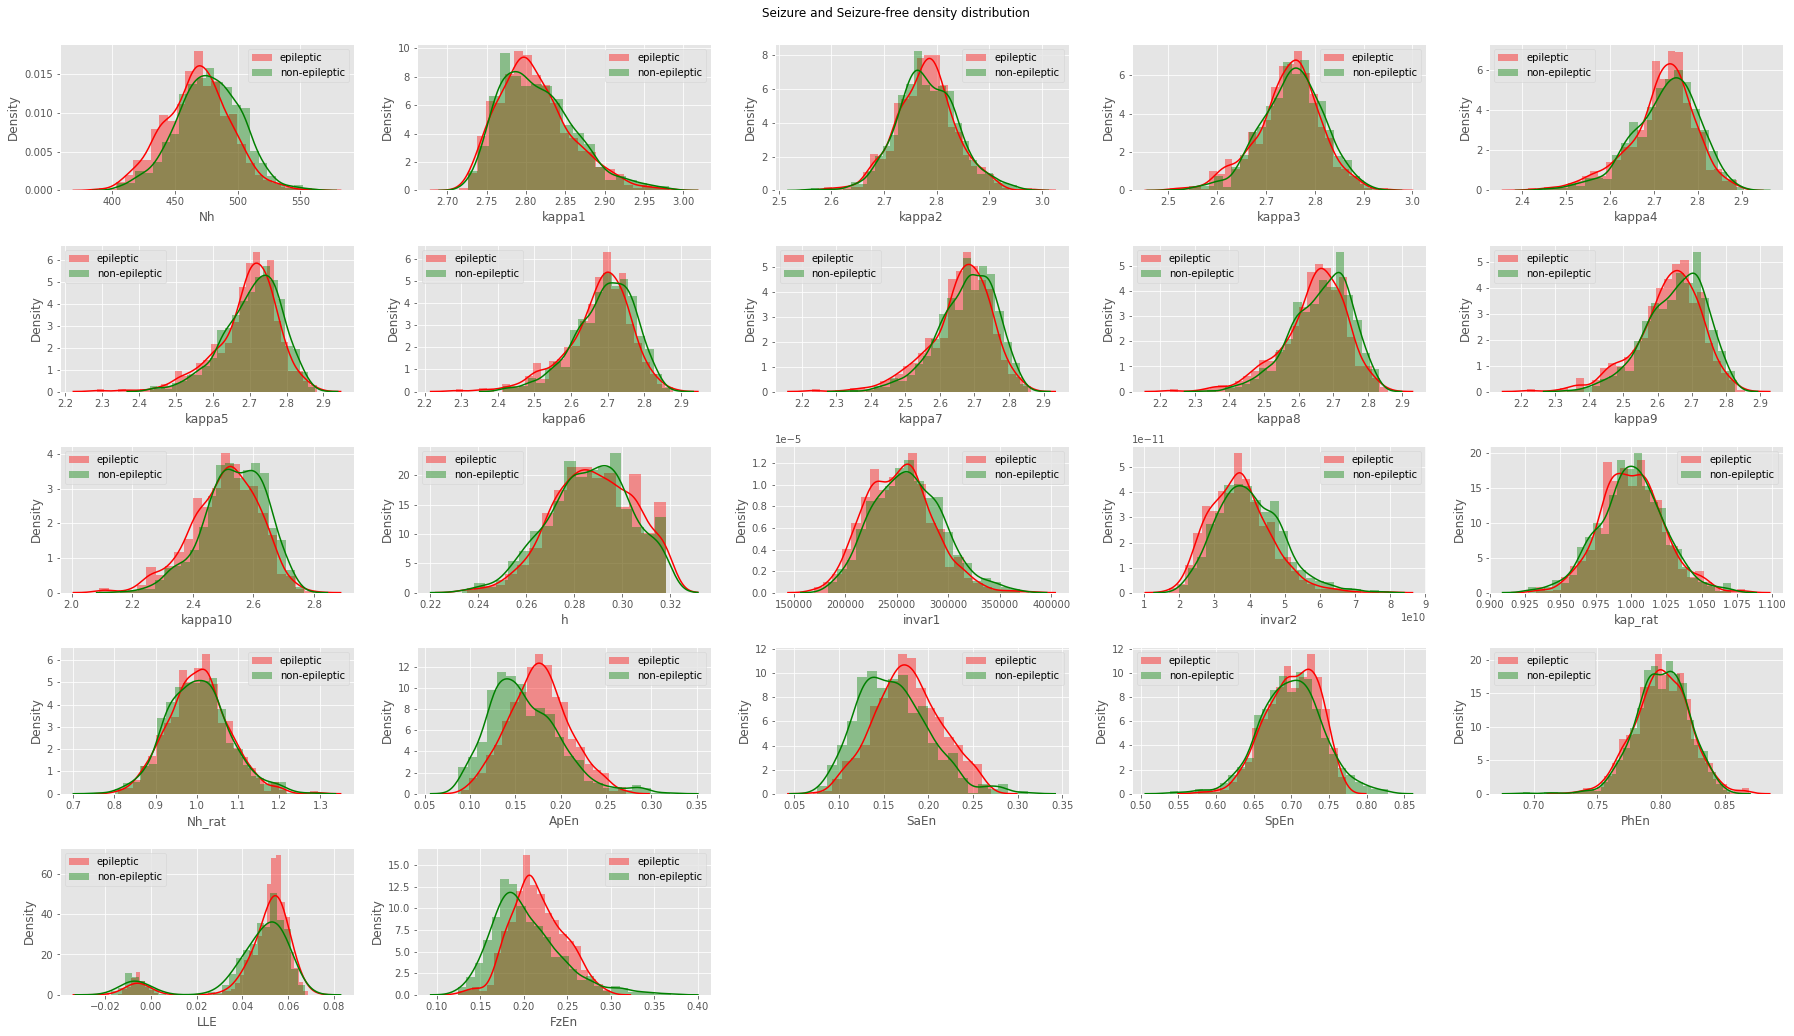

In [920]:
fig = plt.figure(figsize = (25, 17))
j = 0
for i in epileptic_feats.columns:
    plt.subplot(6, 5, j+1)
    j += 1
    sns.distplot(n_epileptic_feats2[i], color='r', label = 'epileptic')
    sns.distplot(n_epileptic_feats[i], color='g', label = 'non-epileptic')
    plt.legend(loc='best')
fig.suptitle('Seizure and Seizure-free density distribution')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [50]:
cols = feats_delta.columns
feats_deltas = pd.DataFrame(scale.fit_transform(feats_delta))
feats_thetas = pd.DataFrame(scale.fit_transform(feats_theta))
feats_alphas = pd.DataFrame(scale.fit_transform(feats_alpha))
feats_betas = pd.DataFrame(scale.fit_transform(feats_beta))
feats_deltas.set_axis(cols, axis=1, inplace=True)
feats_thetas.set_axis(cols, axis=1, inplace=True)
feats_alphas.set_axis(cols, axis=1, inplace=True)
feats_betas.set_axis(cols, axis=1, inplace=True)

In [51]:
freq_feats = pd.DataFrame()
laby = pd.DataFrame([i for i in range(1,5) for j in range(feats_delta.shape[0])])
freq_feats = pd.concat([feats_delta, feats_theta, feats_alpha, feats_beta], axis=1)
freq_feats.reset_index(inplace=True)
del freq_feats['index']
# freq_feats = pd.concat([freq_feats, laby], axis=1)

In [52]:
freq_featsn = pd.DataFrame()
laby = pd.DataFrame([1-i for i in range(2) for j in range(feats_delta.shape[0])])
freq_featsn = pd.concat([feats_deltan, feats_thetan, feats_alphan, feats_betan], axis=1)
freq_featsn.reset_index(inplace=True)
del freq_featsn['index']
# freq_featsn = pd.concat([freq_featsn, laby], axis=1)

In [53]:
freq_feats_all = pd.concat([freq_feats, freq_featsn], axis=0)
freq_feats_all.reset_index(inplace=True)
del freq_feats_all['index']

freq_feats_all = pd.concat([freq_feats_all, pd.DataFrame(laby)], axis=1)

freq_feats_all.set_axis(['Nh_d', 'kappa1_d', 'kappa2_d', 'kappa3_d', 'kappa4_d', 'kappa5_d',
                'kappa6_d', 'kappa7_d', 'kappa8_d', 'kappa9_d', 'kappa10_d',
                'h_d', 'invar1_d', 'invar2_d', 'kap_rat_d', 'Nh_rat_d',
                'ApEn_d', 'SaEn_d', 'SpEn_d', 'PhEn_d', 'LLE_d', 'FzEn_d', 
                'Nh_t', 'kappa1_t',  'kappa2_t', 'kappa3_t', 'kappa4_t', 'kappa5_t',
                'kappa6_t', 'kappa7_t', 'kappa8_t', 'kappa9_t', 'kappa10_t',
                'h_t', 'invar1_t', 'invar2_t', 'kap_rat_t', 'Nh_rat_t',
                'ApEn_t', 'SaEn_t', 'SpEn_t', 'PhEn_t', 'LLE_t', 'FzEn_t',
                'Nh_a', 'kappa1_a',  'kappa2_a', 'kappa3_a', 'kappa4_a', 'kappa5_a',
                'kappa6_a', 'kappa7_a', 'kappa8_a', 'kappa9_a', 'kappa10_a',
                'h_a', 'invar1_a', 'invar2_a', 'kap_rat_a', 'Nh_rat_a',
                'ApEn_a', 'SaEn_a', 'SpEn_a', 'PhEn_a', 'LLE_a', 'FzEn_a',
                'Nh_b', 'kappa1_b',  'kappa2_b', 'kappa3_b', 'kappa4_b', 'kappa5_b',
                'kappa6_b', 'kappa7_b', 'kappa8_b', 'kappa9_b', 'kappa10_b',
                'h_b', 'invar1_b', 'invar2_b', 'kap_rat_b', 'Nh_rat_b',
                'ApEn_b', 'SaEn_b', 'SpEn_b', 'PhEn_b', 'LLE_b', 'FzEn_b', 'labels']
                , axis=1, inplace=True)

##### Feature exploration

In [ ]:
#Generattion of correlation heatmaps
def cross_corr(feats):
    corr = feats.corr(method = 'spearman')

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(15, 12))
        ax = sns.heatmap(corr, mask=mask,  linewidths=0.01, yticklabels=(epileptic_feats[:len(epileptic_feats.columns)-1]).columns,
                        xticklabels=(epileptic_feats[:len(epileptic_feats.columns)-1]).columns, vmin=-1, annot=True, square=True, cmap = "viridis")
    return corr

In [ ]:
corr1 = cross_corr(pd.DataFrame(scale.fit_transform(epileptic_feats)))
corr2 = cross_corr(pd.DataFrame(scale.fit_transform(n_epileptic_feats)))

In [ ]:
corr1 = cross_corr(feats_delta.iloc[:, :len(feats_beta.columns)])
corr2 = cross_corr(feats_theta.iloc[:, :len(feats_beta.columns)])
corr3 = cross_corr(feats_alpha.iloc[:, :len(feats_beta.columns)])
corr4 = cross_corr(feats_beta.iloc[:, :len(feats_beta.columns)])

In [ ]:
plt.figure()
plt.plot(feats_beta_all['h'][feats_beta_all[0]==0], feats_beta_all['PhEn'][feats_beta_all[0]==0], 'o', color='r')
plt.plot(feats_beta_all['h'][feats_beta_all[0]==1], feats_beta_all['PhEn'][feats_beta_all[0]==1], 'o', color='g')
plt.xlabel('invar1')
plt.ylabel('SaEn')

In [ ]:
columns = np.full((corr1.shape[0],), True, dtype=bool)
for i in range(corr1.shape[0]):
    for j in range(i+1, corr1.shape[0]):
        if corr4.iloc[i,j] >= 0.7:
            if columns[j]:
                columns[j] = False
                
selected_columns = feats_delta.columns[columns]
data = feats_beta[selected_columns]

##### Feature selection

In [5]:
#Function to plot the features importance
plt.style.use("ggplot")
def plot_imp(best_features, scores, method_name): 
    plt.figure(figsize=(12,9))  
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

In [336]:
#computing feature importance based on the ANalysis Of VAriance (ANOVA) 
Data = freq_feats_all.drop(columns = 'labels').values
target = freq_feats_all['labels']
Data = preprocessing.MinMaxScaler().fit_transform(Data)
target = preprocessing.LabelEncoder().fit_transform(target)

fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=25)
fs_fit_fscore.fit_transform(Data, target)
fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:25]

best_features_fscore = freq_feats_all.columns[fs_indices_fscore].values

feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]

plot_imp(best_features_fscore, feature_importances_fscore, 'F-Score')

NameError: name 'freq_feats_all' is not defined

In [57]:
selected_columns = freq_feats_all.columns[fs_indices_fscore]
data = freq_feats_all[selected_columns]
data['labels'] = freq_feats_all['labels']

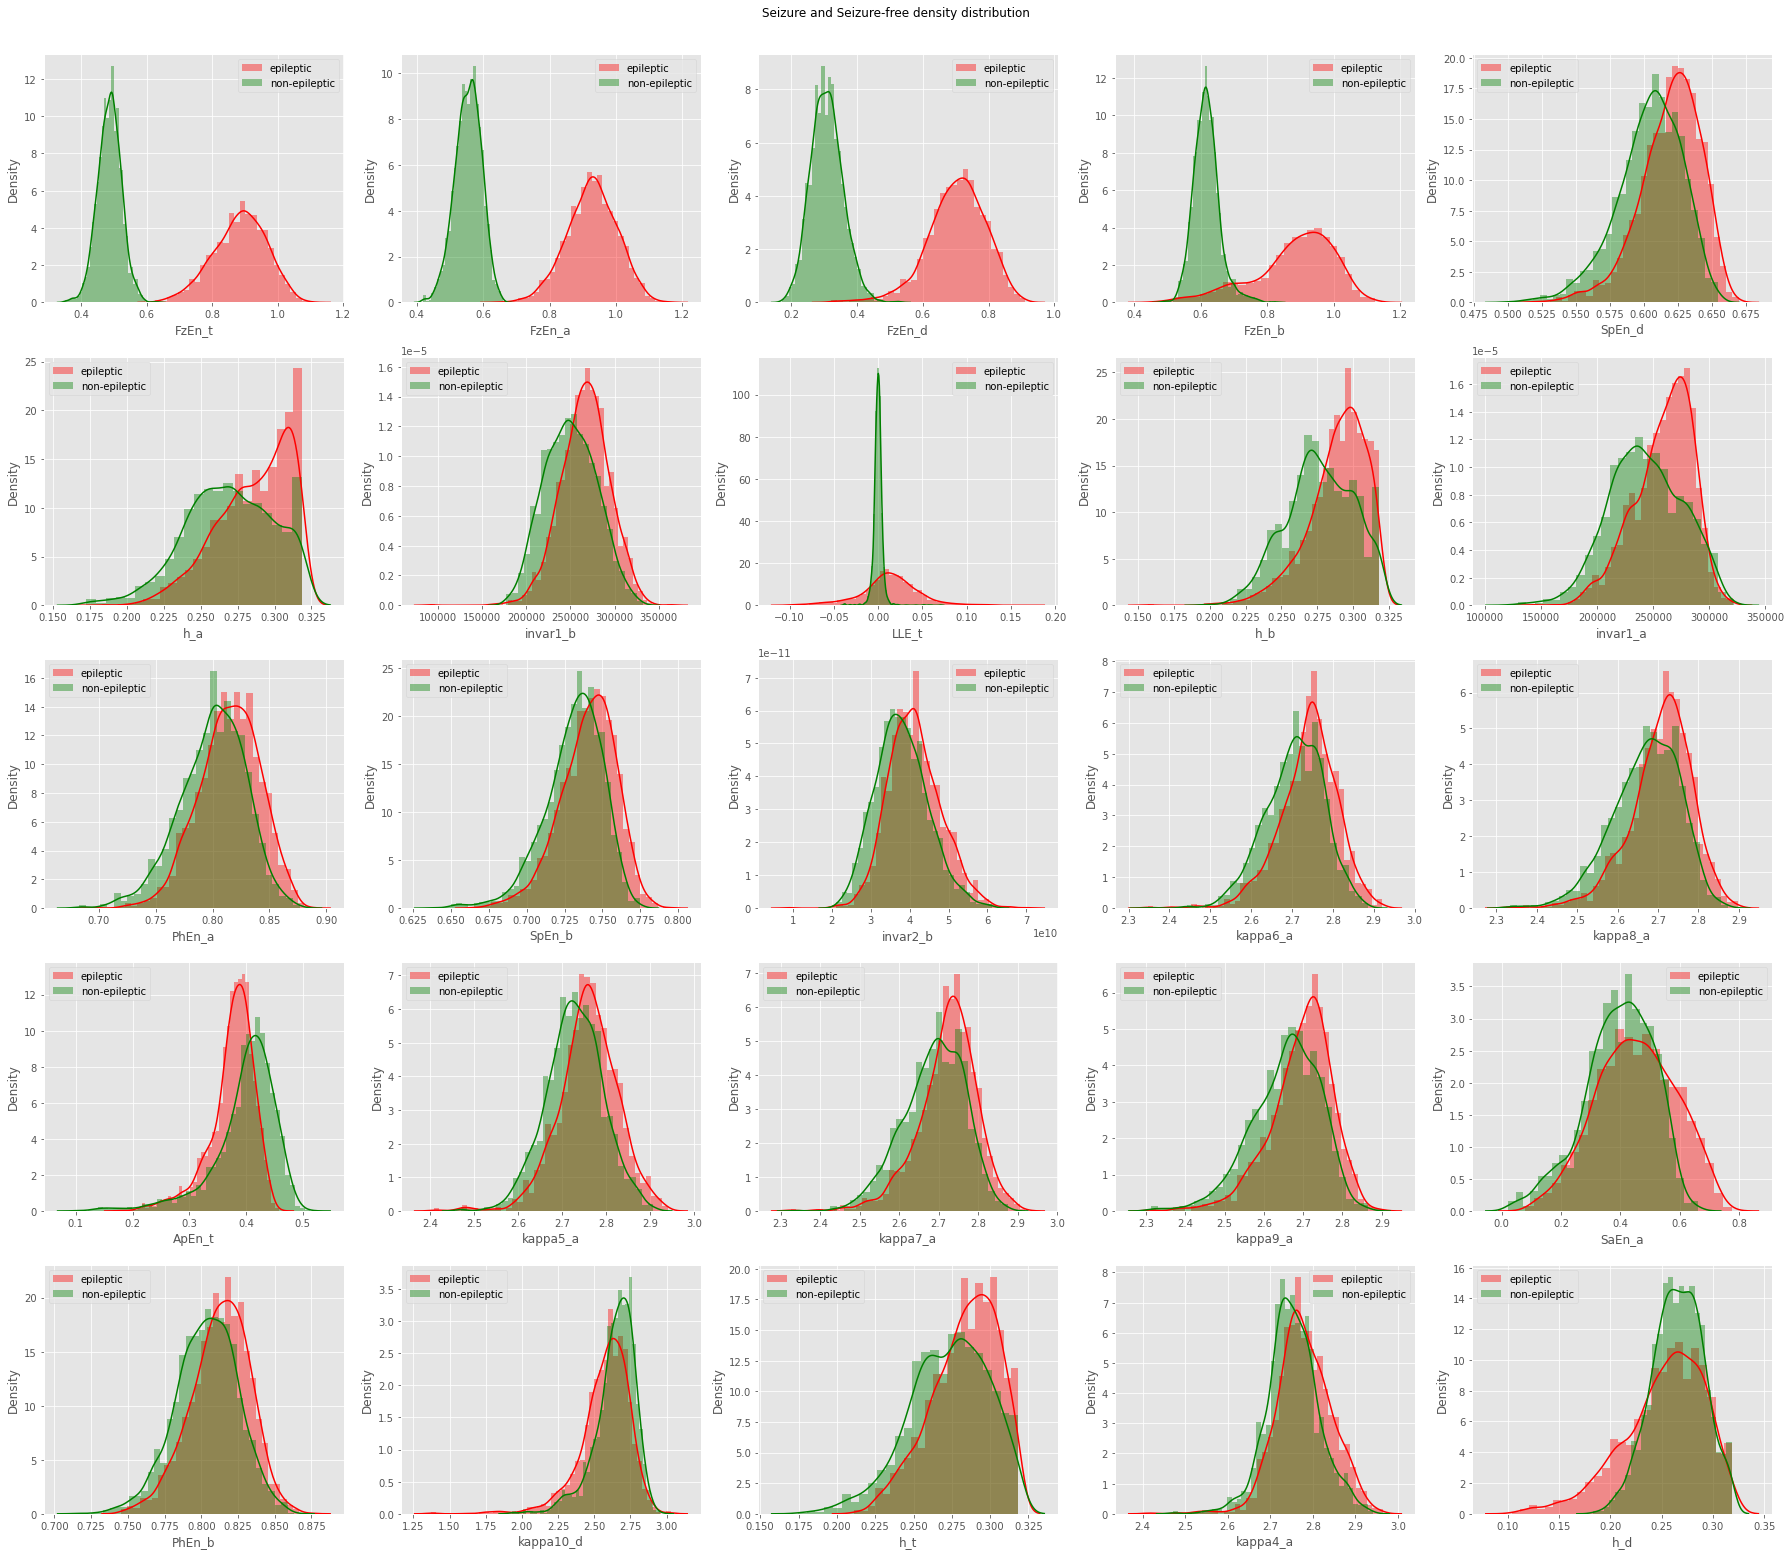

In [50]:
fig = plt.figure(figsize = (25, 22))
j = 0
for i in selected_columns:
    plt.subplot(5, 5, j+1)
    j += 1
    sns.distplot(data[i][data['labels']==1], color='r', label = 'epileptic')
    sns.distplot(data[i][data['labels']==0], color='g', label = 'non-epileptic')
    plt.legend(loc='best')
fig.suptitle('Seizure and Seizure-free density distribution')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j] == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.2
data_modeled, selected_columns = backwardElimination(pd.DataFrame(scale.fit_transform(data)).values, feats_all_lab.iloc[:,-1], SL, selected_columns)

data1 = pd.DataFrame(data = data_modeled, columns = selected_columns)

data2 = pd.concat([data1, pd.DataFrame(labels)], axis=1)

##### Generative Adversial Networks

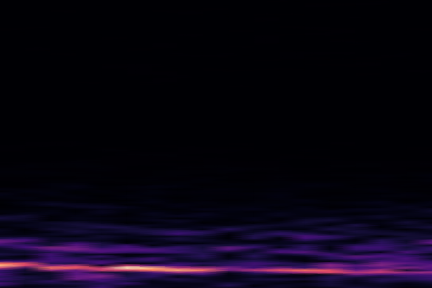

In [992]:
#generation of spectrograms of the epileptic segments as images
S = []
for i in range(100):
    f, t, Sxx = signal.spectrogram(dat_ep['SEG'+str(i+1)], mode='magnitude', fs=173.61, window='hanning')

    mpl.rcParams['savefig.pad_inches'] = 0
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.pcolormesh(t, f, Sxx, shading='gouraud', cmap='magma')
    # plt.ylim([0,32])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    plt.savefig('spectrograms/' + str(i+1) + '.png')

In [133]:
# Download all images from a file and upload them to a list
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
            images.append(img)
    return images

data = load_images_from_folder("spectrograms")

In [11]:
def resize (imgs_category):
    for i in range(len(imgs_category)) :
        imgs_category[i] = cv.resize(imgs_category[i], (108, 72))
resize(data)

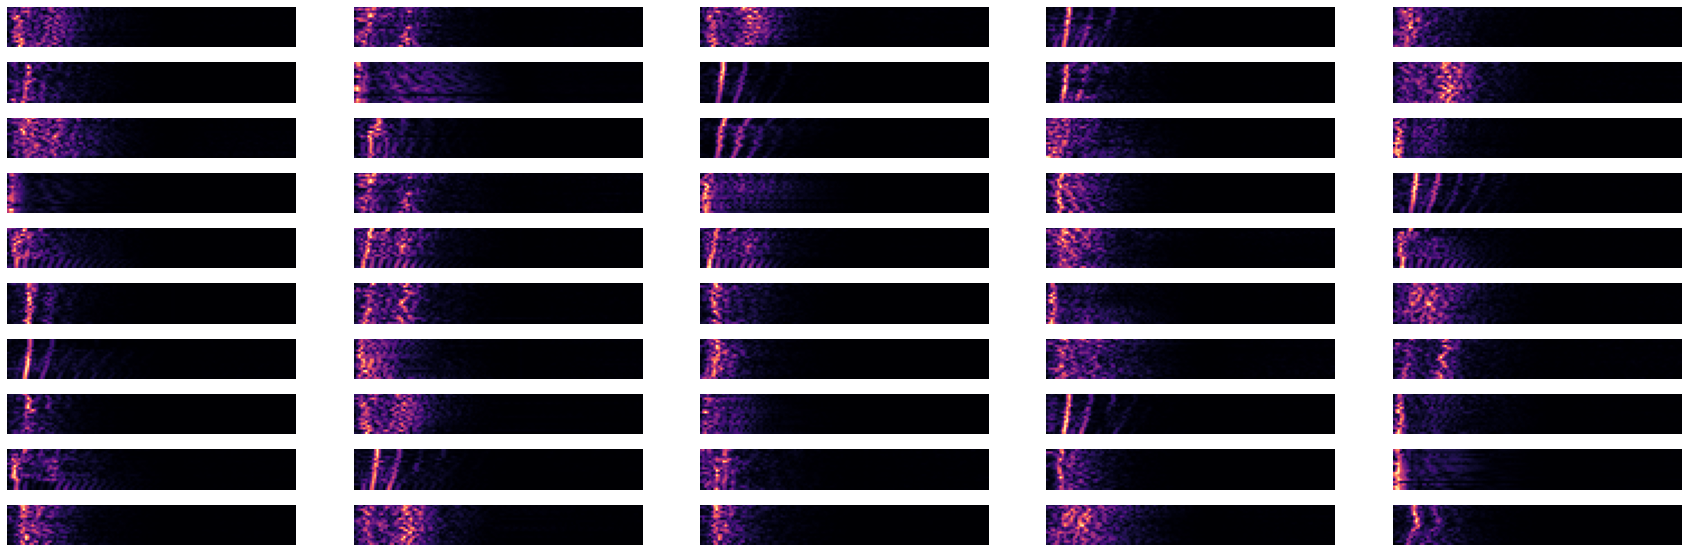

In [921]:
plt.figure(figsize=(30,10))
for i in range(50):
	# define subplot
	plt.subplot(10, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(S[i].T, cmap='magma')

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 65, 9, 64)         640       
                                                                 
 leaky_re_lu_72 (LeakyReLU)  (None, 65, 9, 64)         0         
                                                                 
 dropout_32 (Dropout)        (None, 65, 9, 64)         0         
                                                                 
 conv2d_45 (Conv2D)          (None, 33, 5, 64)         36928     
                                                                 
 leaky_re_lu_73 (LeakyReLU)  (None, 33, 5, 64)         0         
                                                                 
 dropout_33 (Dropout)        (None, 33, 5, 64)         0         
                                                                 
 flatten_16 (Flatten)        (None, 10560)           

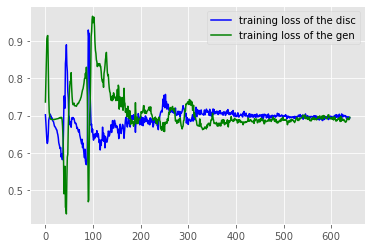

In [690]:
# define the standalone discriminator model
def define_discriminator(in_shape=(S[0].shape[0],S[1].shape[1],1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	model.summary()
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = int(356 * S[0].shape[0] * S[0].shape[1]/9)
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((int(S[0].shape[0]/3), int(S[0].shape[1]/3), 356)))
	# upsample to 14x14
	model.add(Conv2DTranspose(356, (3,3), strides=(1,1), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(356, (3,3), strides=(3,3), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (int(S[0].shape[0]/3), int(S[0].shape[1]/3)), activation='sigmoid', padding='same'))
	model.summary()
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	trainX = np.array(S)
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	# X = X / np.max(S)
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=3):
	# plot images
	fig = plt.figure(figsize=(3,9))
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='magma')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

acc_r = []
acc_f = []

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=9):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	acc_r.append(acc_real)
	acc_f.append(acc_fake)
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=160, n_batch=25):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	loss_d = []
	loss_g = []
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			loss_d.append(d_loss)
			loss_g.append(g_loss)
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
	plt.figure()
	plt.plot(loss_d, 'blue', label='training loss of the disc')
	plt.plot(loss_g, 'green', label='training loss of the gen')
	plt.legend()
	return X_fake

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
fake_data = train(g_model, d_model, gan_model, dataset, latent_dim)

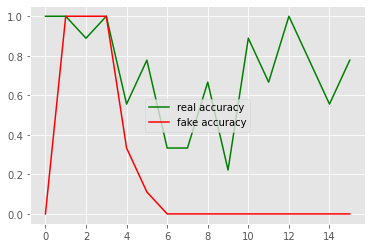

In [695]:
plt.plot(acc_r, 'g', label='real accuracy')
plt.plot(acc_f, 'r', label='fake accuracy')
plt.legend()

In [45]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
# load model
X_=[]
model = load_model('generator_model_130.h5')
# all 0s
latent_dim = 100
for i in range(100):
    vector = randn(100)
    vector = vector.reshape(1, latent_dim)
# vector = asarray([[ 1.8 for _ in range(100)]])
# generate image
    X = model.predict(vector)
    X_.append(X)
# plot the result

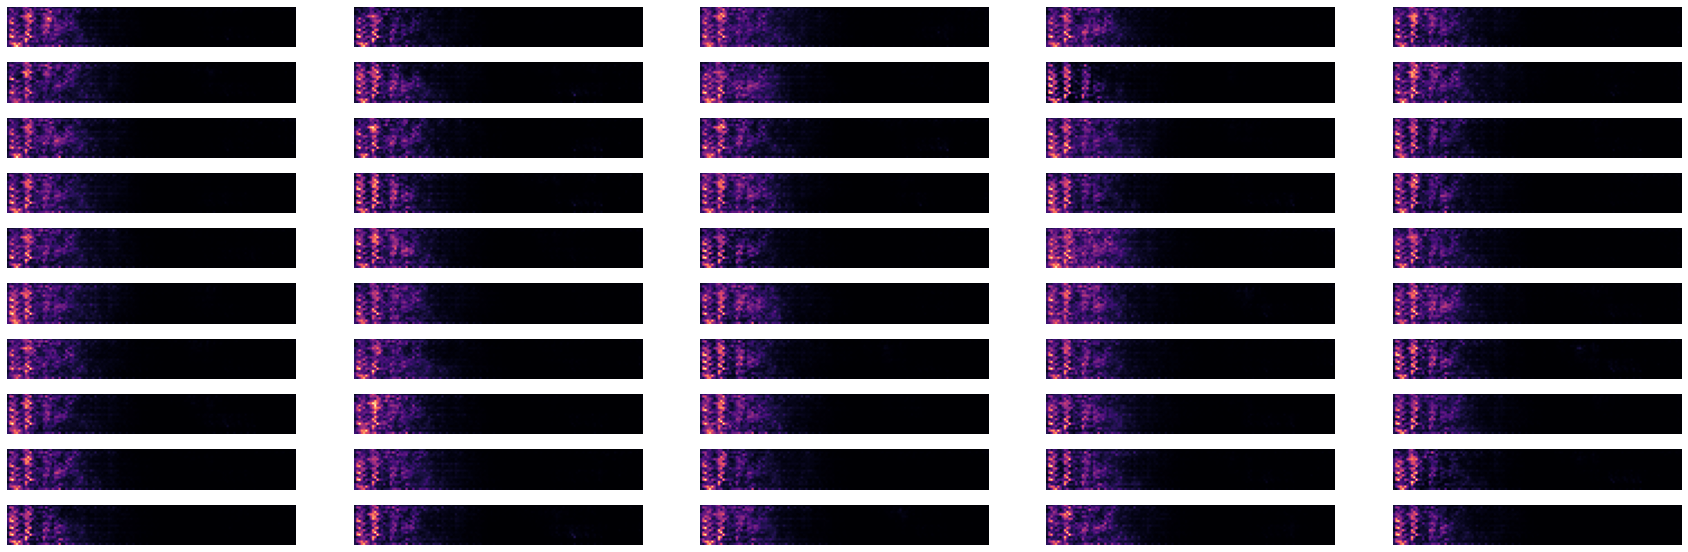

In [784]:
plt.figure(figsize=(30,10))
for i in range(50):
	# define subplot
	plt.subplot(10, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow((X_[i].reshape(129, 18)).T, cmap='magma')

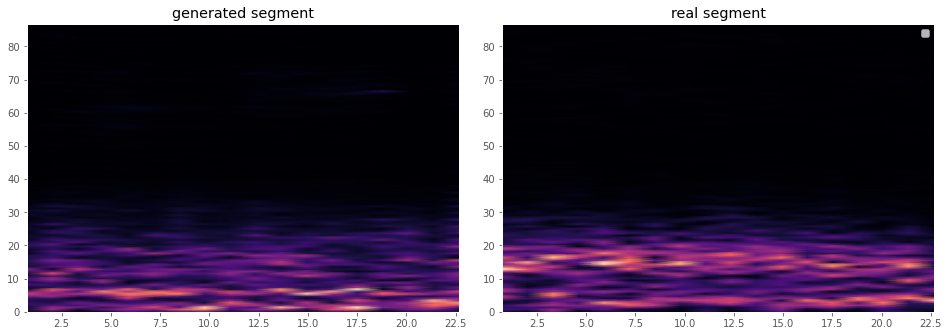

In [941]:
mpl.rcParams['savefig.pad_inches'] = 0.1
ax = plt.axes([0,0,1,1], frameon=True)
ax.pcolormesh(t, f, X_[71].reshape(129,18), shading='gouraud', cmap='magma')
plt.title('generated segment')
ax = plt.axes([1.1,0,1,1], frameon=True)
ax.pcolormesh(t, f, S[75], shading='gouraud', cmap='magma')
plt.title('real segment')
plt.legend()

In [46]:
from math import sin, pi
import random

def inverse_spectrogram(f: np.ndarray, t: np.ndarray, Sxx: np.ndarray, fs: int) -> np.ndarray:
    """inverse_spectrogram calculates the inverse spectrogram
    from frequencies f, intervals t, magnitude matrix Sxx using the sample rate fs.
    Returns signal as a np.array
    """
    #you can not hear the phase they say
    phases = [random.uniform(0,2*pi) for j in range(len(f))]
    #that +1 is here for off by one rounding errors i dont care to chase
    length= int(t[-1]*fs+1)
    #time axis
    out = np.zeros(length)
    for i in range(1,len(t)):
        duration = t[i] - t[i-1]
        start =  t[i-1] * fs
        tics = int(duration*fs)
        for tic in range(tics):
            index = int(start + tic)
            #frequency axis
            for j in range(len(f)):
                magnitude = Sxx[j][i]
                #everyone loves the sin, because it starts from the zero
                out[index] += sin(2*pi/fs*f[j]*index+ phases[j]) * magnitude
    return out

Text(0.5, 0, 'redone')

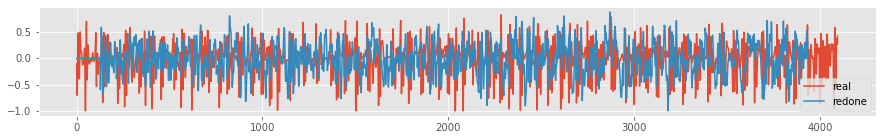

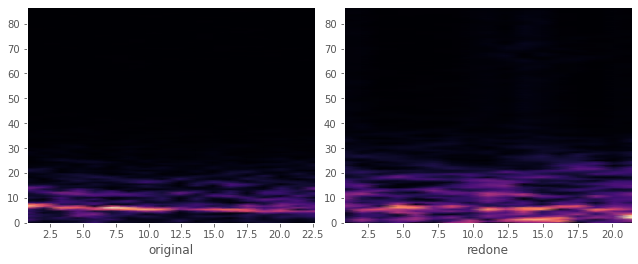

In [23]:
# f, t, Sxx = signal.spectrogram(dat_ep['SEG'+str(10)], mode='magnitude', fs=173.61, window='hanning')
plt.figure(figsize=(15,2))
plt.plot(dat_ep['SEG'+str(10)]/np.max(np.abs(dat_ep['SEG'+str(10)])), label='real')
plt.plot(A/np.max(np.abs(A)), label='redone')
plt.legend()
f1, t1, Sxx1 = signal.spectrogram(A, mode='magnitude', fs=173.61, window='hanning')
plt.figure(figsize=(4,3))
mpl.rcParams['savefig.pad_inches'] = 0.1
ax = plt.axes([0,0,1,1], frameon=True)
ax.pcolormesh(t, f, Sxx, shading='gouraud', cmap='magma')
ax.set_xlabel('original')
ax = plt.axes([1.1,0,1,1], frameon=True)
ax.pcolormesh(t1, f1, Sxx1, shading='gouraud', cmap='magma')
ax.set_xlabel('redone')

In [30]:
k = 0
for i in range(100):
    k = k + dat_ep['SEG'+str(i+1)]
k = k/100 

In [61]:
g = 0
for i in range(100):
    g = g + dat_gen[i]
g = g/100 

In [64]:
ss = 0
for i in range(100):
    ss = ss + S[i]
ss = ss/100 

In [66]:
xx = 0
for i in range(100):
    xx = xx + X_[i].reshape(129,18)
xx = xx/100 

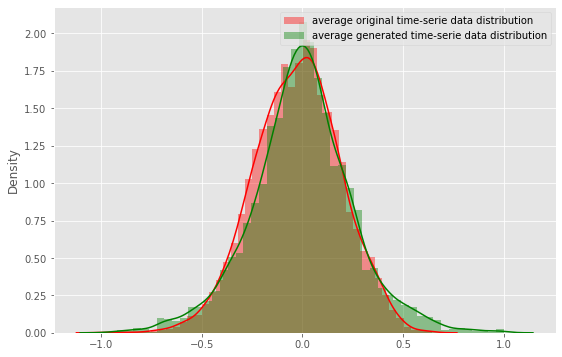

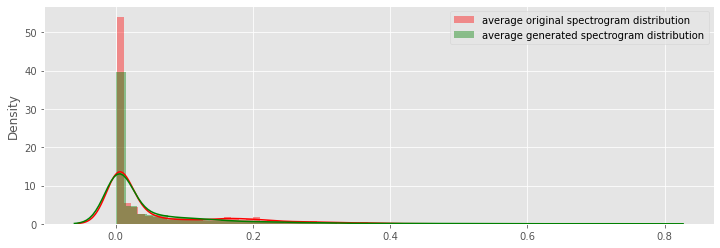

In [86]:
# A = inverse_spectrogram(f, t, X_[77].reshape(129,18), fs=173.61)
plt.figure(figsize=(9,6))
sns.distplot(k/np.max(np.abs(k)), color='red', label = 'average original time-serie data distribution')
# sns.distplot(dat_ep['SEG25']/np.max(np.abs(dat_ep['SEG25'])), color='pink', label = 'SEG25')
# sns.distplot(dat_ep['SEG88']/np.max(np.abs(dat_ep['SEG88'])), color='purple', label = 'SEG88')
# sns.distplot(dat_ep['SEG54']/np.max(np.abs(dat_ep['SEG54'])), color='yellow', label = 'SEG54')
# sns.distplot(dat_ep['SEG22']/np.max(np.abs(dat_ep['SEG22'])), color='orange', label = 'SEG22')
sns.distplot(g/np.max(np.abs(g)), color='g', label = 'average generated time-serie data distribution')
# plt.xlabel('time-series data distribution')
# sns.distplot(X[0, :, :, 0], color='g', label = 'generated')

plt.legend()

plt.figure(figsize=(12,4))
sns.distplot(ss, color='red', label = 'average original spectrogram distribution')
# sns.distplot(S[24], color='pink', label = 'SEG25')
# sns.distplot(S[87], color='purple', label = 'SEG88')
# sns.distplot(S[53], color='yellow', label = 'SEG54')
# sns.distplot(S[21], color='orange', label = 'SEG22')
sns.distplot(xx, color='g', label = 'average generated spectrogram distribution')
# plt.xlabel('spectrograms distribution')
plt.legend()

Text(0.5, 0, 'original')

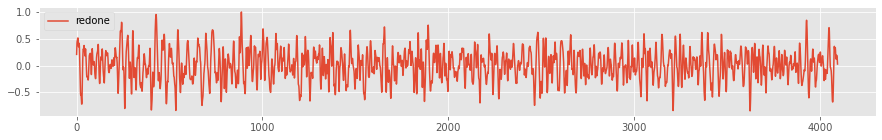

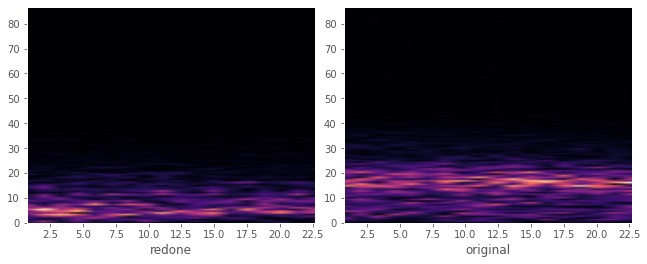

In [47]:
import librosa

# Load an audio file and calculate STFT.
x = dat_ep['SEG'+str(59)]
sample_rate = 173.61
D = librosa.stft(np.array(x.astype(float)))
mag, actual_phase = librosa.magphase(D)
# Try to reconstruct the phase using the iterative algorithm above.
phase = np.exp(1.j * np.random.uniform(0., 2*np.pi, size=actual_phase.shape))
x_ = librosa.istft(mag * phase)

plt.figure(figsize=(15,2))
plt.plot(x_/np.max(np.abs(x_)), label='redone')
# plt.figure(figsize=(30,4))
# plt.plot(dat_ep['SEG'+str(10)]/np.max(np.abs(dat_ep['SEG'+str(10)])), label='real')
plt.legend()
plt.figure(figsize=(4,3))
f, t, Sxx = signal.spectrogram(x_, mode='magnitude', fs=173.61)
mpl.rcParams['savefig.pad_inches'] = 0.1
ax = plt.axes([0,0,1,1], frameon=True)
ax.pcolormesh(t, f, Sxx, shading='gouraud', cmap='magma')
ax.set_xlabel('redone')
f, t, Sxx = signal.spectrogram(dat_ep['SEG'+str(10)], mode='magnitude', fs=173.61)
mpl.rcParams['savefig.pad_inches'] = 0.1
ax = plt.axes([1.1,0,1,1], frameon=True)
ax.pcolormesh(t, f, Sxx, shading='gouraud', cmap='magma')
ax.set_xlabel('original')

In [50]:
np.array(X_[5]).reshape(129,18).shape

(129, 18)

In [48]:
SEG = []
for i in range(100):
    seg = inverse_spectrogram(f, t, X_[i].reshape(129,18), fs=173)
    SEG.append((seg))

In [49]:
dat_gen = pd.DataFrame(np.array(SEG).reshape(3923,100))
number = 4096 - dat_gen.shape[0]
zeroes = zeros(number*100) .reshape(number,100)
dat_gen = pd.concat([pd.DataFrame(zeroes), dat_gen], axis=0)
dat_gen.reset_index(inplace=True)
del dat_gen['index']

##### Classification

In [50]:
data_epi = pd.concat([dat_nep, dat_nep2, dat_ep])
data_epi.reset_index(inplace=True)
del data_epi['index']

labely = pd.DataFrame([1 for i in range(4096)])
dat_gen = pd.concat([dat_gen, pd.DataFrame(labely)], axis=1)
dat_gen.columns = dat_ep.columns

dat_f = pd.concat([data_epi, dat_gen], axis=0)
dat_f.reset_index(inplace=True)
del dat_f['index']
dat_f. rename(columns = {0:'labels'}, inplace = True)

In [47]:
feats_E = df_ep_feats(dat_f, 1, 5, 2, 0.15)

feats_N = df_ep_feats(dat_f, 0, 5, 2, 0.15)

In [53]:
# this is the temporal filtered data
lab = [1 for i in range(int(dat_f.shape[0]/2))]
filtered_ep_delta = pd.DataFrame(filtering_df(dat_f, 8, 0.5, 4, 1))
filtered_ep_delta = pd.concat([filtered_ep_delta, pd.DataFrame(lab)], axis=1)
filtered_ep_delta.columns = dat_f.columns
filtered_ep_theta = pd.DataFrame(filtering_df(dat_f, 8, 4, 8, 1))
filtered_ep_theta = pd.concat([filtered_ep_theta, pd.DataFrame(lab)], axis=1)
filtered_ep_theta.columns = dat_f.columns
filtered_ep_alpha = pd.DataFrame(filtering_df(dat_f, 8, 8, 12, 1))
filtered_ep_alpha = pd.concat([filtered_ep_alpha, pd.DataFrame(lab)], axis=1)
filtered_ep_alpha.columns = dat_f.columns
filtered_ep_beta = pd.DataFrame(filtering_df(dat_f, 8, 12, 30, 1))
filtered_ep_beta = pd.concat([filtered_ep_beta, pd.DataFrame(lab)], axis=1)
filtered_ep_beta.columns = dat_f.columns

In [54]:
# this is the temporal filtered data
lab = [ 0 for i in range(int(dat_f.shape[0]/2))]
filtered_nep_delta = pd.DataFrame(filtering_df(dat_f, 8, 0.5, 4, 0))
filtered_nep_delta = pd.concat([filtered_nep_delta, pd.DataFrame(lab)], axis=1)
filtered_nep_delta.columns = df_seiz.columns
filtered_nep_theta = pd.DataFrame(filtering_df(dat_f, 8, 4, 8, 0))
filtered_nep_theta = pd.concat([filtered_nep_theta, pd.DataFrame(lab)], axis=1)
filtered_nep_theta.columns = df_seiz.columns
filtered_nep_alpha = pd.DataFrame(filtering_df(dat_f, 8, 8, 12, 0))
filtered_nep_alpha = pd.concat([filtered_nep_alpha, pd.DataFrame(lab)], axis=1)
filtered_nep_alpha.columns = df_seiz.columns
filtered_nep_beta = pd.DataFrame(filtering_df(dat_f, 8, 12, 30, 0))
filtered_nep_beta = pd.concat([filtered_nep_beta, pd.DataFrame(lab)], axis=1)
filtered_nep_beta.columns = dat_f.columns

In [57]:
feats_delta = df_ep_feats(filtered_ep_delta,1, 5, 2, 0.15)
feats_theta = df_ep_feats(filtered_ep_theta,1, 5, 2, 0.15)
feats_alpha = df_ep_feats(filtered_ep_alpha,1, 5, 2, 0.15)
feats_beta = df_ep_feats(filtered_ep_beta,1, 5, 2, 0.15)

feats_deltan = df_ep_feats(filtered_nep_delta,0, 5, 2, 0.15)
feats_thetan = df_ep_feats(filtered_nep_theta,0, 5, 2, 0.15)
feats_alphan = df_ep_feats(filtered_nep_alpha,0, 5, 2, 0.15)
feats_betan = df_ep_feats(filtered_nep_beta,0, 5, 2, 0.15)

feats_delta_all = pd.concat([feats_delta, feats_deltan], axis=0)
feats_theta_all = pd.concat([feats_theta, feats_thetan], axis=0)
feats_alpha_all = pd.concat([feats_alpha, feats_alphan], axis=0)
feats_beta_all = pd.concat([feats_beta, feats_betan], axis=0)

labs = pd.DataFrame([1 for i in range(feats_delta.shape[0])])
labels2 = pd.DataFrame([0 for i in range(feats_delta.shape[0])])
labels = pd.concat([labs, labels2])
labels.reset_index(inplace=True)
del labels['index']

feats_delta_all.reset_index(inplace=True)
del feats_delta_all['index']
feats_delta_all = pd.concat([feats_delta_all, pd.DataFrame(labels)], axis=1)

feats_theta_all.reset_index(inplace=True)
del feats_theta_all['index']
feats_theta_all = pd.concat([feats_theta_all, pd.DataFrame(labels)], axis=1)

feats_alpha_all.reset_index(inplace=True)
del feats_alpha_all['index']
feats_alpha_all = pd.concat([feats_alpha_all, pd.DataFrame(labels)], axis=1)

feats_beta_all.reset_index(inplace=True)
del feats_beta_all['index']
feats_beta_all = pd.concat([feats_beta_all, pd.DataFrame(labels)], axis=1)

In [63]:
freq_feats = pd.DataFrame()
laby = pd.DataFrame([i for i in range(1,5) for j in range(feats_delta.shape[0])])
freq_feats = pd.concat([feats_delta, feats_theta, feats_alpha, feats_beta], axis=1)
freq_feats.reset_index(inplace=True)
del freq_feats['index']
# freq_feats = pd.concat([freq_feats, laby], axis=1)

freq_featsn = pd.DataFrame()
laby = pd.DataFrame([1-i for i in range(2) for j in range(feats_delta.shape[0])])
freq_featsn = pd.concat([feats_deltan, feats_thetan, feats_alphan, feats_betan], axis=1)
freq_featsn.reset_index(inplace=True)
del freq_featsn['index']
# freq_featsn = pd.concat([freq_featsn, laby], axis=1)

freq_feats_all = pd.concat([freq_feats, freq_featsn], axis=0)
freq_feats_all.reset_index(inplace=True)
del freq_feats_all['index']

freq_feats_all = pd.concat([freq_feats_all, pd.DataFrame(laby)], axis=1)

freq_feats_all.set_axis(['Nh_d', 'kappa1_d', 'kappa2_d', 'kappa3_d', 'kappa4_d', 'kappa5_d',
                'kappa6_d', 'kappa7_d', 'kappa8_d', 'kappa9_d', 'kappa10_d',
                'h_d', 'invar1_d', 'invar2_d', 'kap_rat_d', 'Nh_rat_d',
                'ApEn_d', 'SaEn_d', 'SpEn_d', 'PhEn_d', 'LLE_d', 'FzEn_d', 
                'Nh_t', 'kappa1_t',  'kappa2_t', 'kappa3_t', 'kappa4_t', 'kappa5_t',
                'kappa6_t', 'kappa7_t', 'kappa8_t', 'kappa9_t', 'kappa10_t',
                'h_t', 'invar1_t', 'invar2_t', 'kap_rat_t', 'Nh_rat_t',
                'ApEn_t', 'SaEn_t', 'SpEn_t', 'PhEn_t', 'LLE_t', 'FzEn_t',
                'Nh_a', 'kappa1_a',  'kappa2_a', 'kappa3_a', 'kappa4_a', 'kappa5_a',
                'kappa6_a', 'kappa7_a', 'kappa8_a', 'kappa9_a', 'kappa10_a',
                'h_a', 'invar1_a', 'invar2_a', 'kap_rat_a', 'Nh_rat_a',
                'ApEn_a', 'SaEn_a', 'SpEn_a', 'PhEn_a', 'LLE_a', 'FzEn_a',
                'Nh_b', 'kappa1_b',  'kappa2_b', 'kappa3_b', 'kappa4_b', 'kappa5_b',
                'kappa6_b', 'kappa7_b', 'kappa8_b', 'kappa9_b', 'kappa10_b',
                'h_b', 'invar1_b', 'invar2_b', 'kap_rat_b', 'Nh_rat_b',
                'ApEn_b', 'SaEn_b', 'SpEn_b', 'PhEn_b', 'LLE_b', 'FzEn_b', 'labels']
                , axis=1, inplace=True)

In [3]:
freq_feats_all = pd.read_csv('freq_feats_all.csv')
del freq_feats_all['Unnamed: 0']

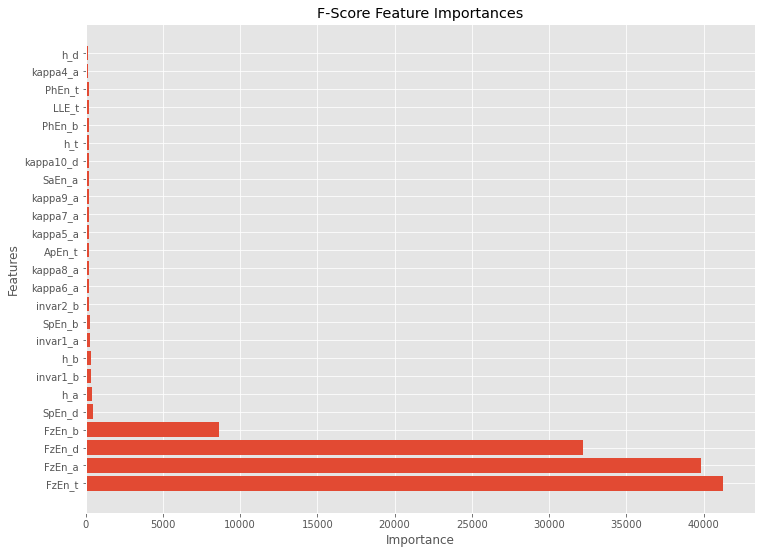

In [6]:
Data = freq_feats_all.drop(columns = 'labels').values
target = freq_feats_all['labels']
Data = preprocessing.MinMaxScaler().fit_transform(Data)
target = preprocessing.LabelEncoder().fit_transform(target)

fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=25)
fs_fit_fscore.fit_transform(Data, target)
fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:25]

best_features_fscore = freq_feats_all.columns[fs_indices_fscore].values

feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]

plot_imp(best_features_fscore, feature_importances_fscore, 'F-Score')

In [7]:
selected_columns = freq_feats_all.columns[fs_indices_fscore]
data = freq_feats_all[selected_columns]
data['labels'] = freq_feats_all['labels']

In [14]:
scsa_feat = ['h_a', 'invar1_b', 'h_b', 'invar1_a', 'invar2_b', 'kappa6_a', 'kappa8_a', 'kappa5_a', 
                'kappa7_a', 'kappa9_a', 'kappa10_d', 'h_t', 'kappa4_a', 'h_d', 'labels']

nonlin_feat = ['FzEn_t', 'FzEn_a', 'FzEn_d', 'FzEn_b', 'SpEn_d', 'SpEn_b', 'ApEn_t', 'SaEn_a',
                'PhEn_b', 'LLE_t', 'PhEn_t', 'labels']

scsa_feats = data[scsa_feat]
nonlin_feats = data[nonlin_feat]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:25], data.iloc[:,25], test_size=0.3, random_state=42)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

def score_plot(prediction, score):
    cm = metrics.confusion_matrix(y_test, prediction)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap='Oranges')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 10)

In [36]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
predictions_svm = clf.predict(X_test)

In [10]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
X = data.iloc[:,:25]
y = data.iloc[:,25]

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
specificity = make_scorer(recall_score, pos_label=0)
sensitivity = make_scorer(recall_score, pos_label=1)

In [11]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2, tol=0.9)
# logisticRegr.fit(X_train, y_train)
# predictions_lr = logisticRegr.predict(X_test)
# score_lr = logisticRegr.score(X_test, y_test)
# score_plot(predictions_lr, score_lr)
cv_lr = cross_val_score(logisticRegr, X, y, cv=cv)
cv_lr1 = cross_val_score(logisticRegr, X, y, cv=cv, scoring=specificity).mean()
cv_lr2 = cross_val_score(logisticRegr, X, y, cv=cv, scoring=sensitivity).mean()

In [12]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB(var_smoothing=3e-21)
# clf_gnb.fit(X_train, y_train)
# predictions_nb  =  clf_gnb.predict(X_test)
# score_nb = clf_gnb.score(X_test, y_test)
# score_plot(predictions_nb, score_nb)
cv_gnb = cross_val_score(clf_gnb, X, y, cv=cv)
cv_gnb1 = cross_val_score(clf_gnb, X, y, cv=cv, scoring=specificity).mean()
cv_gnb2 = cross_val_score(clf_gnb, X, y, cv=cv, scoring=sensitivity).mean()

In [13]:
from sklearn.tree import DecisionTreeClassifier

clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
# clf_en.fit(X_train, y_train)
# predictions_dt = clf_en.predict(X_test)
# score_dt = clf_en.score(X_test, y_test)
# score_plot(predictions_dt, score_dt)
cv_dt = cross_val_score(clf_en, X, y, cv=cv)
cv_dt1 = cross_val_score(clf_en, X, y, cv=cv, scoring=specificity).mean()
cv_dt2 = cross_val_score(clf_en, X, y, cv=cv, scoring=sensitivity).mean()

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=1, criterion='entropy', max_depth=2, random_state=0)
# clf.fit(X_train, y_train)
# predictions_rf = clf.predict(X_test)
# score_rf = clf.score(X_test, y_test)
# score_plot(predictions_rf, score_rf)
cv_rf = cross_val_score(clf_rf, X, y, cv=cv)
cv_rf1 = cross_val_score(clf_rf, X, y, cv=cv, scoring=specificity).mean()
cv_rf2 = cross_val_score(clf_rf, X, y, cv=cv, scoring=sensitivity).mean()

In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf_qda = QDA()
# clf.fit(X_train, y_train)
# predictions_qda = clf.predict(X_test)
# score_qda = clf.score(X_test, y_test)
# score_plot(predictions_qda, score_qda)
cv_qda = cross_val_score(clf_qda, X, y, cv=cv)
cv_qda1 = cross_val_score(clf_qda, X, y, cv=cv, scoring=specificity).mean()
cv_qda2 = cross_val_score(clf_qda, X, y, cv=cv, scoring=sensitivity).mean()

In [951]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

clf_kn = KNeighborsClassifier(n_neighbors = 235, weights='distance', p=1)
# clf.fit(X_train, y_train)
# predictions_knn = clf.predict(X_test)
# score_knn = clf.score(X_test, y_test)
# score_plot(predictions_knn, score_knn)
cv_kn = cross_val_score(clf_kn, X, y, cv=cv)
cv_kn1 = cross_val_score(clf_kn, X, y, cv=cv, scoring=specificity).mean()
cv_kn2 = cross_val_score(clf_kn, X, y, cv=cv, scoring=sensitivity).mean()

In [950]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(solver='adam', alpha=9, activation = 'logistic', tol=0.2,
                        hidden_layer_sizes=(5, 30, 20, 8, 5), max_iter = 100, random_state=112)
# clf.fit(X_train,y_train)
# predictions_mlp = clf.predict(X_test)
# score_mlp = clf.score(X_test, y_test)
# score_plot(predictions_mlp, score_mlp)
cv_mlp = cross_val_score(clf_mlp, X, y, cv=cv)
cv_mlp1 = cross_val_score(clf_mlp, X, y, cv=cv, scoring=specificity).mean()
cv_mlp2 = cross_val_score(clf_mlp, X, y, cv=cv, scoring=sensitivity).mean()

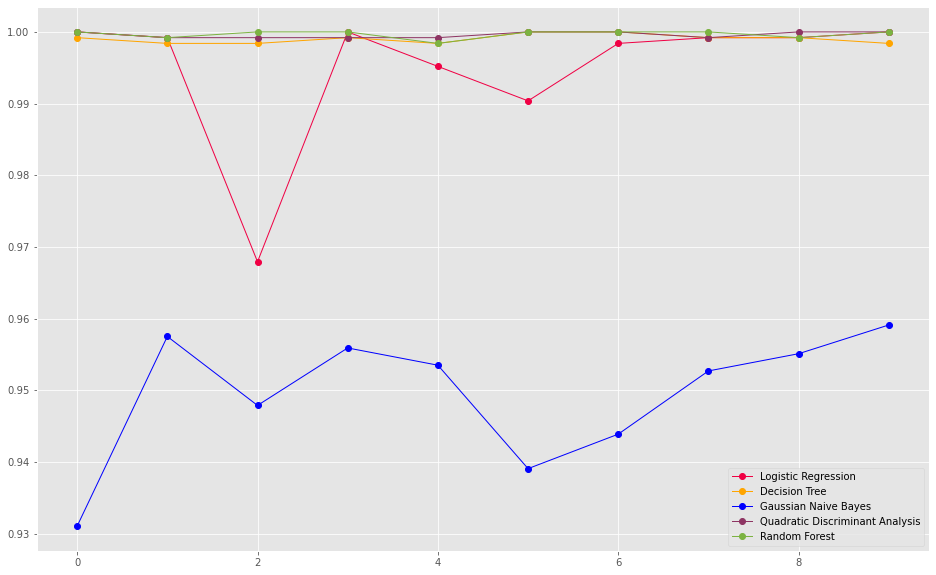

In [17]:
plt.figure(figsize=(16,10))
plt.yscale('linear') 
plt.plot(cv_lr,'o-',  color='#F00044', label='Logistic Regression',markeredgewidth=1, linewidth=1)
plt.plot(cv_dt,'o-', color='orange', label='Decision Tree',markeredgewidth=1, linewidth=1)
plt.plot(cv_gnb,'o-', color='blue', label='Gaussian Naive Bayes',markeredgewidth=1, linewidth=1)
plt.plot(cv_qda,'o-', color='#8e3563', label='Quadratic Discriminant Analysis',markeredgewidth=1, linewidth=1)
plt.plot(cv_rf,'o-', color='#7cb342', label='Random Forest',markeredgewidth=1, linewidth=1)
# plt.plot(cv_kn,'o-', color='#7cb342', label='K-Nearest Neighbors',markeredgewidth=0.8, linewidth=0.6)
# plt.plot(cv_mlp,'o-', color='#F00044', label='Muliple Layer Perceptron',markeredgewidth=0.8, linewidth=0.6)
plt.legend()

In [960]:
scores = [0.99, 0.99, 0.93, 1, 0.99, 0.63, 0.52]

In [970]:
s1 = [cv_lr1, cv_dt1, cv_gnb1, cv_qda1, cv_rf1, cv_kn1, cv_mlp1]
s2 = [cv_lr2, cv_dt2, cv_gnb2, cv_qda2, cv_rf2, cv_kn2, cv_mlp2]

all = np.array([s1, s2, scores]).reshape(3,7)

<AxesSubplot:>

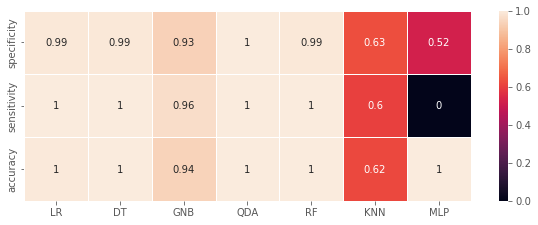

In [987]:
xs = ['LR', 'DT', 'GNB', 'QDA', 'RF', 'KNN', 'MLP']
ys = ['specificity', 'sensitivity', 'accuracy']

plt.figure(figsize=(10,3.5))
sns.heatmap(all, annot=True, xticklabels=xs, yticklabels=ys, linewidths=0.5, cmap='rocket')